In [23]:
import json
from pathlib import Path
from collections import defaultdict

TOOLS = ["frizbee", "pinny", "semgrep", "scorecard", "poutine", "scharf", "zizmor", "actionlint", "ggshield"]
base_dir = Path("../tools_output")
output_dir = Path("../results/merged") 
output_dir.mkdir(parents=True, exist_ok=True)

workflow_results = defaultdict(dict)

for tool in TOOLS:
    tool_dir = base_dir / tool / "workflow_with_issues"
    if not tool_dir.exists():
        continue

    for wf_file in tool_dir.glob("*.json"):
        # Normalize to unify .yml/.yaml
        workflow_name = wf_file.stem
        if workflow_name.endswith(".yaml"):
            workflow_name = workflow_name.replace(".yaml", ".yml")

        with open(wf_file, "r", encoding="utf-8") as f:
            tool_result = json.load(f)
            workflow_results[workflow_name][tool] = tool_result

# Save merged results
for wf_name, tool_dict in workflow_results.items():
    merged = {
        "workflow": wf_name,
        "tools": tool_dict
    }
    with open(output_dir / f"{wf_name}.json", "w", encoding="utf-8") as out_f:
        json.dump(merged, out_f, indent=2)

print(f"[✓] Saved {len(workflow_results)} merged workflow files to {output_dir}")


[✓] Saved 596 merged workflow files to ../results/merged


In [24]:
import json
import csv
from pathlib import Path
from collections import defaultdict

# Directories
input_dir = Path("../results/merged")
output_dir = Path("../results/normalized")
mapping_file = Path("../capabilities/rules_mapping.csv")

output_dir.mkdir(parents=True, exist_ok=True)

# ----------------------------
# Ordered: Most specific -> Least specific
# ----------------------------
ACTIONLINT_PATTERNS = [
    (["[action]", "action is too old to run on GitHub Actions"], "pinning-check"),
    (["[expression]", "undefined variable"], "workflow_structural_check"),
    (["[expression]", "undefined function"], "workflow_structural_check"),
    (["[expression]", "is not defined in object type"], "workflow_structural_check"),
    (["[expression]", "value cannot be compared to"], "control-flow-check"),
    (["[expression]", "untrusted"], "injection-check"),
    (["[expression]", "by reusable workflow"], "workflow_structural_check"),
    (["[expression]", "availability for more details"], "workflow_structural_check"),
    (["[workflow-call]"], "workflow_structural_check"),
    (["[syntax-check]"], "workflow_structural_check"),
    (["[expression]"], "control-flow-check"),
    (["[shellcheck]"], "workflow_structural_check"),
    (["[pyflakes]"], "workflow_structural_check"),
    (["[job-needs]"], "workflow_structural_check"),
    (["[matrix]"], "workflow_structural_check"),
    (["[events]"], "workflow_structural_check"),
    (["[glob]"], "workflow_structural_check"),
    (["[runner-label]"], "workflow_structural_check"),
    (["[action]"], "workflow_structural_check"),
    (["[shell-name]"], "workflow_structural_check"),
    (["[id]"], "workflow_structural_check"),
    (["[credentials]"], "secrets-check"),
    (["[env-var]"], "workflow_structural_check"),
    (["[permissions]"], "permissions-check"),
    (["[deprecated-commands]"], "injection-check"),
    (["[if-cond]"], "control-flow-check"),
]

# ----------------------------
# Load all other tools' rules
# ----------------------------
rule_map = defaultdict(list)
with open(mapping_file, newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        tool = row["tool_name"].strip()
        if tool == "actionlint":
            continue  # Skip, handled manually
        rule = row["rule"].strip()
        cap = row["capability"].strip()
        rule_map[(tool, rule)].append(cap)

# ----------------------------
# Match actionlint: first matching pattern wins
# ----------------------------
def match_actionlint_capability(message):
    msg = message.lower()
    for keywords, capability in ACTIONLINT_PATTERNS:
        if all(kw.lower() in msg for kw in keywords):
            return capability
    return None

# ----------------------------
# Generic capability assignment
# ----------------------------
def get_capability(tool, finding, rule_hint=None):
    for key in ["rule", "rule_id", "name"]:
        if key in finding:
            rule_val = finding[key]
            if (tool, rule_val) in rule_map:
                return rule_map[(tool, rule_val)][0]

    if rule_hint and (tool, rule_hint) in rule_map:
        return rule_map[(tool, rule_hint)][0]

    if tool == "actionlint" and "message" in finding:
        return match_actionlint_capability(finding["message"])

    return None

# ----------------------------
# Main Processing Loop
# ----------------------------
for file_path in input_dir.glob("*.json"):
    with open(file_path, encoding="utf-8") as f:
        data = json.load(f)

    for tool, result in data.get("tools", {}).items():
        findings = result.get("findings", [])

        # For tools like scharf where rule is only in summary
        by_rule = result.get("summary", {}).get("by_rule", {})
        if tool == "scharf" and by_rule:
            for rule_name in by_rule:
                cap = rule_map.get((tool, rule_name), [None])[0]
                if cap:
                    for finding in findings:
                        finding["capability"] = cap
            continue

        # Normal tools and actionlint
        for finding in findings:
            cap = get_capability(tool, finding)
            if cap:
                finding["capability"] = cap

    # Save final output
    output_file = output_dir / file_path.name
    with open(output_file, "w", encoding="utf-8") as out_f:
        json.dump(data, out_f, indent=2)

print(f"[✓] Normalized and saved files to: {output_dir}")


[✓] Normalized and saved files to: ../results/normalized


In [61]:
import json
import csv
from pathlib import Path
from collections import defaultdict

# Directories
input_dir = Path("../results/normalized")
output_csv = Path("../results/tools_findings_summary.csv")

# Collect all tool names and findings
all_tools = set()
all_workflows = []

for file_path in input_dir.glob("*.json"):
    with open(file_path, encoding="utf-8") as f:
        data = json.load(f)

    workflow_name = data.get("workflow", file_path.stem)
    tool_counts = {}

    for tool_name, tool_data in data.get("tools", {}).items():
        findings = tool_data.get("findings", [])
        count = len(findings)
        tool_counts[tool_name] = count
        all_tools.add(tool_name)

    all_workflows.append((workflow_name, tool_counts))

# Sort workflows alphabetically
all_workflows.sort(key=lambda x: x[0].lower())

# Prepare CSV rows
all_tools = sorted(all_tools)
header = ["workflow"] + all_tools

with open(output_csv, "w", newline='', encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(header)

    for wf_name, tool_counts in all_workflows:
        row = [wf_name] + [tool_counts.get(tool, 0) for tool in all_tools]
        writer.writerow(row)

print(f"findings summary saved to: {output_csv}")


findings summary saved to: ../results/tools_findings_summary.csv


In [62]:
import json
from pathlib import Path
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Directories
input_dir = Path("../results/normalized")
output_dir = Path("../results/violin_plots")
output_dir.mkdir(exist_ok=True)

# Collect counts: (capability, tool) → [counts per workflow]
data = []

for file_path in input_dir.glob("*.json"):
    with open(file_path, encoding="utf-8") as f:
        workflow_data = json.load(f)

    workflow = workflow_data.get("workflow", file_path.stem)

    for tool_name, tool_data in workflow_data.get("tools", {}).items():
        findings = tool_data.get("findings", [])
        cap_count = defaultdict(int)

        for finding in findings:
            cap = finding.get("capability")
            if cap:
                cap_count[cap] += 1

        for cap, count in cap_count.items():
            data.append({
                "workflow": workflow,
                "tool": tool_name,
                "capability": cap,
                "count": count
            })

# Convert to DataFrame
df = pd.DataFrame(data)

# Plot violin plot for each capability
capabilities = df["capability"].unique()

for cap in capabilities:
    cap_df = df[df["capability"] == cap]
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=cap_df, y="tool", x="count", inner="box", scale="width")
    plt.title(f"{cap}")
    plt.ylabel("Number of Findings")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(output_dir / f"{cap}_violin.png")
    plt.close()

print(f"[✓] Violin plots saved to: {output_dir}")


/tmp/ipykernel_183476/2223073776.py:48: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=cap_df, y="tool", x="count", inner="box", scale="width")
/tmp/ipykernel_183476/2223073776.py:48: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=cap_df, y="tool", x="count", inner="box", scale="width")
/tmp/ipykernel_183476/2223073776.py:48: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=cap_df, y="tool", x="count", inner="box", scale="width")


/tmp/ipykernel_183476/2223073776.py:48: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=cap_df, y="tool", x="count", inner="box", scale="width")
/tmp/ipykernel_183476/2223073776.py:48: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=cap_df, y="tool", x="count", inner="box", scale="width")
/tmp/ipykernel_183476/2223073776.py:48: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=cap_df, y="tool", x="count", inner="box", scale="width")
/tmp/ipykernel_183476/2223073776.py:48: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=cap_df, y="tool", x="count", inne

[✓] Violin plots saved to: ../results/violin_plots


In [52]:
import json
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Paths
input_dir = Path("../results/normalized")
output_dir = Path("../results")
output_csv = output_dir / "capability_coverage_matrix.csv"
output_heatmap = output_dir / "capability_coverage_heatmap.png"

# Data collection
tool_capability = {}

for file_path in input_dir.glob("*.json"):
    with open(file_path, encoding="utf-8") as f:
        data = json.load(f)

    for tool_name, tool_data in data.get("tools", {}).items():
        findings = tool_data.get("findings", [])
        for finding in findings:
            cap = finding.get("capability")
            if cap:
                tool_capability.setdefault(tool_name, set()).add(cap)

# Collect all capabilities and tools
all_capabilities = sorted({cap for caps in tool_capability.values() for cap in caps})
all_tools = sorted(tool_capability.keys())

# Build binary matrix
coverage_matrix = pd.DataFrame(0, index=all_tools, columns=all_capabilities)

for tool, capabilities in tool_capability.items():
    for cap in capabilities:
        coverage_matrix.loc[tool, cap] = 1

# Save to CSV
coverage_matrix.to_csv(output_csv)
print(f"[✓] Capability coverage matrix saved to: {output_csv}")

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(coverage_matrix, cmap="Greens", linewidths=0.5, linecolor='gray', cbar=False, annot=True)
plt.title("Capability Coverage Heatmap (Detected Capabilities)")
plt.xlabel("Capability")
plt.ylabel("Tool")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save heatmap
plt.savefig(output_heatmap, dpi=300)
plt.close()
print(f"[✓] Capability coverage heatmap saved to: {output_heatmap}")


[✓] Capability coverage matrix saved to: ../results/capability_coverage_matrix.csv
[✓] Capability coverage heatmap saved to: ../results/capability_coverage_heatmap.png


In [63]:
import json
from pathlib import Path
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === Paths ===
input_dir = Path("../results/normalized")
output_dir = Path("../results")
output_csv = output_dir / "capability_intensity_matrix.csv"
output_heatmap = output_dir / "capability_intensity_heatmap.png"
output_boxplot_dir = output_dir / "capability_boxplots"
output_boxplot_dir.mkdir(exist_ok=True)

# === Collect Findings ===
intensity = defaultdict(list)  # (tool, cap) -> [counts per workflow]
workflow_counts = []  # For boxplots

for file_path in input_dir.glob("*.json"):
    with open(file_path, encoding="utf-8") as f:
        data = json.load(f)

    workflow = data.get("workflow", file_path.stem)

    for tool, tool_data in data.get("tools", {}).items():
        findings = tool_data.get("findings", [])
        cap_count = defaultdict(int)

        for f in findings:
            cap = f.get("capability")
            if cap:
                cap_count[cap] += 1

        for cap, count in cap_count.items():
            intensity[(tool, cap)].append(count)
            workflow_counts.append({
                "workflow": workflow,
                "tool": tool,
                "capability": cap,
                "count": count
            })

# === Build DataFrames ===

# For heatmap and CSV
tools = sorted({tool for (tool, _) in intensity})
caps = sorted({cap for (_, cap) in intensity})
df_heatmap = pd.DataFrame(0.0, index=tools, columns=caps)

for (tool, cap), values in intensity.items():
    avg = sum(values) / len(values)
    df_heatmap.loc[tool, cap] = avg

# Save CSV
df_heatmap.to_csv(output_csv)

# === Plot Heatmap ===
plt.figure(figsize=(12, 6))
sns.heatmap(df_heatmap, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Average Findings per Capability per Tool")
plt.xlabel("Capability")
plt.ylabel("Tool")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(output_heatmap)
plt.close()

# === Plot Boxplots per Capability ===
df_box = pd.DataFrame(workflow_counts)

for cap in caps:
    cap_df = df_box[df_box["capability"] == cap]
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=cap_df, x="tool", y="count")
    plt.title(f"Boxplot: Findings per Workflow for Capability '{cap}'")
    plt.ylabel("Number of Findings")
    plt.xlabel("Tool")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(output_boxplot_dir / f"{cap}_boxplot.png")
    plt.close()

print(f"[✓] CSV, heatmap, and boxplots saved to: {output_dir}")


[✓] CSV, heatmap, and boxplots saved to: ../results


In [64]:
import json
from pathlib import Path
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === Paths ===
input_dir = Path("../results/normalized")
output_jaccard_workflow = Path("../results/jaccard_similarity_workflows.csv")
output_jaccard_capability = Path("../results/jaccard_similarity_capabilities.csv")
output_plot_workflow = Path("../results/jaccard_similarity_workflows.png")
output_plot_capability = Path("../results/jaccard_similarity_capabilities.png")

# === Collect sets per tool ===
workflow_sets = defaultdict(set)          # tool -> set(workflow)
capability_sets = defaultdict(set)        # tool -> set((workflow, capability))

for file_path in input_dir.glob("*.json"):
    with open(file_path, encoding="utf-8") as f:
        data = json.load(f)
    
    wf = data.get("workflow", file_path.stem)

    for tool, tool_data in data.get("tools", {}).items():
        findings = tool_data.get("findings", [])
        workflow_sets[tool].add(wf)

        for f in findings:
            cap = f.get("capability")
            if cap:
                capability_sets[tool].add((wf, cap))

tools = sorted(set(workflow_sets.keys()) | set(capability_sets.keys()))

# === Function to compute Jaccard Matrix ===
def compute_jaccard_matrix(sets_dict):
    matrix = pd.DataFrame(index=tools, columns=tools, dtype=float)

    for t1 in tools:
        for t2 in tools:
            s1, s2 = sets_dict[t1], sets_dict[t2]
            if s1 or s2:
                intersection = len(s1 & s2)
                union = len(s1 | s2)
                matrix.loc[t1, t2] = intersection / union
            else:
                matrix.loc[t1, t2] = 0.0
    return matrix

# === Compute and Save CSV + Heatmap for both ===
jac_workflow = compute_jaccard_matrix(workflow_sets)
jac_capability = compute_jaccard_matrix(capability_sets)

jac_workflow.to_csv(output_jaccard_workflow)
jac_capability.to_csv(output_jaccard_capability)

# === Plot heatmaps ===
plt.figure(figsize=(10, 8))
sns.heatmap(jac_workflow, annot=True, cmap="Blues", fmt=".2f")
plt.title("Jaccard Similarity of Tools (by Workflow Detection)")
plt.tight_layout()
plt.savefig(output_plot_workflow)
plt.close()

plt.figure(figsize=(10, 8))
sns.heatmap(jac_capability, annot=True, cmap="Greens", fmt=".2f")
plt.title("Jaccard Similarity of Tools (by Capability in Workflow)")
plt.tight_layout()
plt.savefig(output_plot_capability)
plt.close()

print("[✓] Jaccard similarity CSVs and heatmaps saved to ../results")


[✓] Jaccard similarity CSVs and heatmaps saved to ../results


In [55]:
import pandas as pd
from pathlib import Path

# === Paths ===
input_csv = Path("../results/tools_findings_summary.csv")
output_txt = Path("../results/manual_review/selected_workflows.txt")
output_txt.parent.mkdir(exist_ok=True)

# === Load CSV ===
df = pd.read_csv(input_csv, index_col=0)

# === Metadata columns ===
df["total_findings"] = df.sum(axis=1)
df["tool_count"] = (df.iloc[:, :-1] > 0).sum(axis=1)

# === Category A: High Total Findings (top 5) ===
top_findings = df.sort_values("total_findings", ascending=False).head(5)

# === Category B: High Tool Overlap (top 5) ===
top_overlap = df.sort_values("tool_count", ascending=False).head(5)

# === Category C: Low Tool Overlap (tool_count <= 2) ===
low_overlap = df[df["tool_count"] <= 2].sort_values("total_findings", ascending=False).head(5)

# === Category D: Tool-specific interest (1 workflow per tool where only that tool found issues) ===
tool_cols = [col for col in df.columns if col not in ("total_findings", "tool_count")]
tool_unique_picks = []

for tool in tool_cols:
    only_this_tool = df[(df[tool] > 0) & (df["tool_count"] == 1)]
    if not only_this_tool.empty:
        picked = only_this_tool.sort_values("total_findings", ascending=False).head(1)
        tool_unique_picks.append(picked)

tool_specific = pd.concat(tool_unique_picks)

# === Combine and Deduplicate ===
combined = pd.concat([top_findings, top_overlap, low_overlap, tool_specific])
combined = combined[~combined.index.duplicated(keep="first")]

# === Save to file ===
selected_workflows = combined.index.tolist()
with open(output_txt, "w") as f:
    for wf in selected_workflows:
        f.write(wf + "\n")

# === Print categories ===
print("[✓] Selected workflows for manual review (grouped):")
print("\n📈 High total findings:")
print("\n".join(top_findings.index.tolist()))
print("\n🤝 High tool overlap:")
print("\n".join(top_overlap.index.tolist()))
print("\n⚠️ Low tool overlap:")
print("\n".join(low_overlap.index.tolist()))
print(f"\n🎯 Tool-specific interest ({len(tool_specific)} tools):")
print("\n".join(tool_specific.index.tolist()))
print(f"\n[✓] Saved to: {output_txt}")


[✓] Selected workflows for manual review (grouped):

📈 High total findings:
facebook_react__runtime_build_and_test.yml
facebook_watchman__getdeps_linux.yml
facebook_rocksdb__pr-jobs.yml
facebook_watchman__getdeps_mac.yml
facebook_watchman__getdeps_windows.yml

🤝 High tool overlap:
axios_axios__publish.yml
vercel_next.js__setup-nextjs-build.yml
facebook_react-native__test-all.yml
vercel_next.js__trigger_release.yml
vercel_next.js__code_freeze.yml

⚠️ Low tool overlap:
nodejs_node__build-tarball.yml
nodejs_node__daily-wpt-fyi.yml
electron_electron__issue-labeled.yml
electron_electron__branch-created.yml
IBM_sarama__ci.yml

🎯 Tool-specific interest (2 tools):
IBM_sarama__codeql-analysis.yml
tensorflow_tensorflow__osv-scanner-scheduled.yml

[✓] Saved to: ../results/manual_review/selected_workflows.txt


In [65]:
import json
from pathlib import Path
import csv

# === Paths ===
input_dir = Path("../results/normalized")
output_dir = Path("../results/manual_review")
output_dir.mkdir(exist_ok=True)

# === Load workflow filenames ===
with open(output_dir / "selected_workflows.txt", "r", encoding="utf-8") as f:
    selected_workflows = [line.strip() for line in f if line.strip()]

# === Generate summaries ===
for wf_file in selected_workflows:
    wf_path = input_dir / wf_file
    if not wf_path.exists():
        print(f"[!] Workflow not found: {wf_file}")
        continue

    with open(wf_path, encoding="utf-8") as f:
        data = json.load(f)

    findings_data = []

    for tool, tool_data in data.get("tools", {}).items():
        findings = tool_data.get("findings", [])
        for f in findings:
            # Default values
            line = f.get("line", None)
            column = f.get("column", None)
            message = f.get("message", f.get("reason", f.get("note", None)))

            # Fallbacks from meta
            if not line and isinstance(f.get("meta"), dict):
                line = f["meta"].get("line_number") or f["meta"].get("line", "N/A")
            if not column and isinstance(f.get("meta"), dict):
                column = f["meta"].get("column", "N/A")

            # === Tool-specific message logic ===
            if tool == "frizbee" and "original" in f:
                message = f["original"]
            elif tool == "pinny" and "meta" in f:
                message = f["meta"].get("action") or f["meta"].get("line_snippet")
            elif not message and isinstance(f.get("meta"), dict):
                message = f["meta"].get("details", "N/A")

            findings_data.append({
                "tool": tool,
                "capability": f.get("capability", "N/A"),
                "line": line if line is not None else "N/A",
                "column": column if column is not None else "N/A",
                "message": message if message is not None else "N/A"
            })

    # Save to CSV
    out_file = output_dir / f"{wf_file.replace('.json', '')}_summary.csv"
    with open(out_file, "w", newline='', encoding="utf-8") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=["tool", "capability", "line", "column", "message"])
        writer.writeheader()
        writer.writerows(findings_data)

    print(f"[✓] Created summary for: {wf_file}")


[!] Workflow not found: facebook_react__runtime_build_and_test.yml
[!] Workflow not found: facebook_watchman__getdeps_linux.yml
[!] Workflow not found: facebook_rocksdb__pr-jobs.yml
[!] Workflow not found: facebook_watchman__getdeps_mac.yml
[!] Workflow not found: facebook_watchman__getdeps_windows.yml
[!] Workflow not found: axios_axios__publish.yml
[!] Workflow not found: vercel_next.js__setup-nextjs-build.yml
[!] Workflow not found: facebook_react-native__test-all.yml
[!] Workflow not found: vercel_next.js__trigger_release.yml
[!] Workflow not found: vercel_next.js__code_freeze.yml
[!] Workflow not found: nodejs_node__build-tarball.yml
[!] Workflow not found: nodejs_node__daily-wpt-fyi.yml
[!] Workflow not found: electron_electron__issue-labeled.yml
[!] Workflow not found: electron_electron__branch-created.yml
[!] Workflow not found: IBM_sarama__ci.yml
[!] Workflow not found: IBM_sarama__codeql-analysis.yml
[!] Workflow not found: tensorflow_tensorflow__osv-scanner-scheduled.yml


In [66]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Directories
input_dir = "../results/manual_reviewed"
output_dir = "../results"

# Step 1: Aggregate all CSVs
all_data = []
for fname in os.listdir(input_dir):
    if fname.endswith(".csv"):
        df = pd.read_csv(os.path.join(input_dir, fname))
        df['workflow'] = fname.replace(".csv", "")
        all_data.append(df)

df_all = pd.concat(all_data, ignore_index=True)

# Step 2: Inject GGShield manually (before computing any stats)
ggshield_tp = pd.DataFrame([{
    'tool': 'ggshield',
    'capability': 'secret-detection',
    'line': None,
    'column': None,
    'message': 'hardcoded secret',
    'verdict': 'TP',
    'workflow': 'manual_injection'
}])
df_all = pd.concat([df_all, ggshield_tp], ignore_index=True)

# Step 3: Filter for relevant verdicts
df_all = df_all[df_all['verdict'].isin(['TP', 'FP'])]

# Step 4: Precision per tool
tool_summary = (
    df_all.groupby(['tool', 'verdict'])
    .size()
    .unstack(fill_value=0)
    .assign(total=lambda x: x['TP'] + x['FP'])
    .assign(precision=lambda x: x['TP'] / x['total'])
    .sort_values(by='precision', ascending=False)
    .reset_index()
)
tool_summary.to_csv(os.path.join(output_dir, "precision_per_tool.csv"), index=False)

# Step 5: Precision per tool+capability
capability_summary = (
    df_all.groupby(['tool', 'capability', 'verdict'])
    .size()
    .unstack(fill_value=0)
    .assign(total=lambda x: x['TP'] + x['FP'])
    .assign(precision=lambda x: x['TP'] / x['total'])
    .sort_values(by='precision', ascending=False)
    .reset_index()
)
capability_summary.to_csv(os.path.join(output_dir, "precision_per_capability.csv"), index=False)

# Step 6: Plotting tool precision
plt.figure(figsize=(10, 6))
plt.bar(tool_summary['tool'], tool_summary['precision'])
plt.title("Tool Precision (TP / [TP + FP])")
plt.ylabel("Precision")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.05)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "precision_per_tool.png"))
plt.close()


/tmp/ipykernel_183476/914022669.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_all, ggshield_tp], ignore_index=True)


In [19]:
import json
from pathlib import Path
import pandas as pd

# Input path
input_dir = Path("../results/normalized")

# Containers
tools = set()
capabilities = set()
workflow_data = {}

for file_path in input_dir.glob("*.json"):
    workflow_name = file_path.stem
    with open(file_path, encoding="utf-8") as f:
        data = json.load(f)

    for tool, tool_data in data.get("tools", {}).items():
        tools.add(tool)
        findings = tool_data.get("findings", [])
        for finding in findings:
            cap = finding.get("capability")
            if not cap:
                continue

            # ---- Special handling for scorecard ----
            if tool == "scorecard":
                detection_count = len(finding.get("lines", [])) or 1
            else:
                detection_count = 1

            capabilities.add(cap)
            key = (tool, cap)
            workflow_data.setdefault(key, {"count": 0, "workflows": set()})
            workflow_data[key]["count"] += detection_count
            workflow_data[key]["workflows"].add(workflow_name)

# Sorted lists
tools = sorted(tools)
capabilities = sorted(capabilities)

# Build DataFrame
table = pd.DataFrame("", index=tools, columns=capabilities)

for (tool, cap), entry in workflow_data.items():
    count = entry["count"]
    n_workflows = len(entry["workflows"])
    table.loc[tool, cap] = f"{count} ({n_workflows})"

# Fill missing with "0 (0)"
table.replace("", "0 (0)", inplace=True)

# Save to CSV
output_csv = "../results/findings_workflows_table.csv"
table.to_csv(output_csv)
print(f"[✓] Table saved to: {output_csv}")


[✓] Table saved to: ../results/findings_workflows_table.csv


TIME EXECUTION :

In [2]:
import os, subprocess, time, csv

TOOL = "actionlint"
CMD_TEMPLATE = ["./../../tools/actionlint/actionlint"]
WORKFLOW_DIR = "../.github/workflows"
OUTPUT_CSV = f"{TOOL}_times.csv"

results = []
for file in os.listdir(WORKFLOW_DIR):
    if file.endswith((".yml", ".yaml")):
        path = os.path.join(WORKFLOW_DIR, file)
        start = time.perf_counter()
        subprocess.run(CMD_TEMPLATE + [path], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        end = time.perf_counter()
        results.append((file, round(end - start, 4)))

with open(OUTPUT_CSV, "w", newline="") as f:
    csv.writer(f).writerows([("file", "execution_time_seconds")] + results)


In [16]:
import os, subprocess, time, csv

TOOL = "frizbee"
CMD_TEMPLATE = ["./../../tools/frizbee/frizbee", "actions", "-n"]
WORKFLOW_DIR = "../.github/workflows"
OUTPUT_CSV = f"{TOOL}_times.csv"

results = []
for file in os.listdir(WORKFLOW_DIR):
    if file.endswith((".yml", ".yaml")):
        path = os.path.join(WORKFLOW_DIR, file)
        start = time.perf_counter()
        subprocess.run(CMD_TEMPLATE + [path], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        end = time.perf_counter()
        results.append((file, round(end - start, 4)))

with open(OUTPUT_CSV, "w", newline="") as f:
    csv.writer(f).writerows([("file", "execution_time_seconds")] + results)


In [18]:
import os, subprocess, time, csv

TOOL = "pinny"
CMD_TEMPLATE = ["./../../tools/pinny/pinny", "actions", "pin", "--dry-run", "--file"]
WORKFLOW_DIR = "../.github/workflows"
OUTPUT_CSV = f"{TOOL}_times.csv"

results = []
for file in os.listdir(WORKFLOW_DIR):
    if file.endswith((".yml", ".yaml")):
        path = os.path.join(WORKFLOW_DIR, file)
        start = time.perf_counter()
        subprocess.run(CMD_TEMPLATE + [path], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        end = time.perf_counter()
        results.append((file, round(end - start, 4)))

with open(OUTPUT_CSV, "w", newline="") as f:
    csv.writer(f).writerows([("file", "execution_time_seconds")] + results)


In [3]:
import os, subprocess, time, csv

TOOL = "scharf"
CMD_TEMPLATE = ["./../../tools/scharf/scharf", "audit"]
WORKFLOW_DIR = "../.github/workflows"
OUTPUT_CSV = f"{TOOL}_times.csv"

results = []
for file in os.listdir(WORKFLOW_DIR):
    if file.endswith((".yml", ".yaml")):
        path = os.path.join(WORKFLOW_DIR, file)
        start = time.perf_counter()
        subprocess.run(CMD_TEMPLATE + [path], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        end = time.perf_counter()
        results.append((file, round(end - start, 4)))

with open(OUTPUT_CSV, "w", newline="") as f:
    csv.writer(f).writerows([("file", "execution_time_seconds")] + results)


In [4]:
import os, subprocess, time, csv

TOOL = "ggshield"
CMD_TEMPLATE = ["./../../tools/ggshield/ggshield", "secret", "scan", "--all-secrets", "path"]
WORKFLOW_DIR = "../.github/workflows"
OUTPUT_CSV = f"{TOOL}_times.csv"

results = []
for file in os.listdir(WORKFLOW_DIR):
    if file.endswith((".yml", ".yaml")):
        path = os.path.join(WORKFLOW_DIR, file)
        start = time.perf_counter()
        subprocess.run(CMD_TEMPLATE + [path, "--recursive"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        end = time.perf_counter()
        results.append((file, round(end - start, 4)))

with open(OUTPUT_CSV, "w", newline="") as f:
    csv.writer(f).writerows([("file", "execution_time_seconds")] + results)


In [6]:
import os, subprocess, time, csv

TOOL = "zizmor"
CMD_TEMPLATE = ["./../../tools/zizmor/zizmor"]
WORKFLOW_DIR = "../.github/workflows"
OUTPUT_CSV = f"{TOOL}_times.csv"

results = []
for file in os.listdir(WORKFLOW_DIR):
    if file.endswith((".yml", ".yaml")):
        path = os.path.join(WORKFLOW_DIR, file)
        start = time.perf_counter()
        subprocess.run(CMD_TEMPLATE + [path], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        end = time.perf_counter()
        results.append((file, round(end - start, 4)))

with open(OUTPUT_CSV, "w", newline="") as f:
    csv.writer(f).writerows([("file", "execution_time_seconds")] + results)


In [7]:
import os, subprocess, time, csv

TOOL = "poutine"
CMD_TEMPLATE = ["./../../tools/poutine/poutine", "analyze_local"]
WORKFLOW_DIR = "../.github/workflows"
OUTPUT_CSV = f"{TOOL}_times.csv"

results = []
for file in os.listdir(WORKFLOW_DIR):
    if file.endswith((".yml", ".yaml")):
        path = os.path.join(WORKFLOW_DIR, file)
        start = time.perf_counter()
        subprocess.run(CMD_TEMPLATE + [path], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        end = time.perf_counter()
        results.append((file, round(end - start, 4)))

with open(OUTPUT_CSV, "w", newline="") as f:
    csv.writer(f).writerows([("file", "execution_time_seconds")] + results)


In [13]:
import os
import shutil
import subprocess
import time
import csv
from pathlib import Path

TOOL = "semgrep"
WORKFLOW_DIR = Path("../.github/workflows")  # ← Adjust if needed
TEMP_DIR = Path("semgrep_temp")
OUTPUT_CSV = f"{TOOL}_times.csv"

# Setup
TEMP_DIR.mkdir(parents=True, exist_ok=True)
(TEMP_DIR / ".github" / "workflows").mkdir(parents=True, exist_ok=True)
results = []

# Get all .yml and .yaml files
workflow_files = list(WORKFLOW_DIR.glob("*.yml")) + list(WORKFLOW_DIR.glob("*.yaml"))

print(f"[INFO] Found {len(workflow_files)} workflow files.")

for wf in workflow_files:
    print(f"[▶] Scanning: {wf.name}")

    # Clean temp workflows directory
    temp_workflows_dir = TEMP_DIR / ".github" / "workflows"
    for f in temp_workflows_dir.glob("*"):
        f.unlink()

    # Copy file to temp repo structure
    temp_file = temp_workflows_dir / wf.name
    shutil.copy(wf, temp_file)

    # Run semgrep
    start = time.perf_counter()
    result = subprocess.run(
        ["semgrep", "--config", "p/github-actions", "--quiet", str(TEMP_DIR)],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL
    )
    end = time.perf_counter()

    if result.returncode == 0:
        duration = round(end - start, 4)
        results.append((wf.name, duration))
        print(f"    [✓] Success: {duration}s")
    else:
        print(f"    [✗] Failed (code {result.returncode})")

# Save results
with open(OUTPUT_CSV, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["file", "execution_time_seconds"])
    writer.writerows(results)

print(f"\n[✅] Done. Results saved to: {OUTPUT_CSV}")


[INFO] Found 596 workflow files.
[▶] Scanning: oracle_graal__main.yml
    [✓] Success: 19.5654s
[▶] Scanning: huggingface_transformers__build_pr_documentation.yml
    [✓] Success: 17.4415s
[▶] Scanning: oracle_docker-images__build-and-push-instantclient-images.yml
    [✓] Success: 17.7987s
[▶] Scanning: nodejs_node__find-inactive-tsc.yml
    [✓] Success: 18.0656s
[▶] Scanning: yt-dlp_yt-dlp__quick-test.yml
    [✓] Success: 15.5909s
[▶] Scanning: twbs_bootstrap__lint.yml
    [✓] Success: 13.8205s
[▶] Scanning: electron_electron__pipeline-electron-build-and-test-and-nan.yml
    [✓] Success: 13.0586s
[▶] Scanning: twbs_bootstrap__issue-labeled.yml
    [✓] Success: 12.9484s
[▶] Scanning: facebook_react__shared_label_core_team_prs.yml
    [✓] Success: 12.6465s
[▶] Scanning: facebook_react__compiler_typescript.yml
    [✓] Success: 12.8731s
[▶] Scanning: huggingface_transformers__self-past-caller.yml
    [✓] Success: 13.0715s
[▶] Scanning: electron_electron__pipeline-segment-electron-gn-check

In [15]:
import os
import shutil
import subprocess
import time
import csv
from pathlib import Path

TOOL = "scorecard"
WORKFLOW_DIR = Path("../.github/workflows")
TEMP_REPO_DIR = Path("scorecard_tmp_repo")
OUTPUT_CSV = f"{TOOL}_times.csv"

# Ensure temp repo structure
TEMP_REPO_DIR.mkdir(parents=True, exist_ok=True)
(TEMP_REPO_DIR / ".github" / "workflows").mkdir(parents=True, exist_ok=True)

results = []

# Get list of YAML files
yml_files = list(WORKFLOW_DIR.glob("*.yml")) + list(WORKFLOW_DIR.glob("*.yaml"))
print(f"[INFO] Found {len(yml_files)} workflow files.")

for wf in yml_files:
    print(f"[▶] Scanning: {wf.name}")

    # Clean previous workflow in temp
    temp_wf_dir = TEMP_REPO_DIR / ".github" / "workflows"
    for f in temp_wf_dir.glob("*"):
        f.unlink()

    # Copy current workflow to temp
    temp_file = temp_wf_dir / wf.name
    shutil.copy(wf, temp_file)

    # Run Scorecard
    start = time.perf_counter()
    result = subprocess.run(
        ["./../../tools/scorecard/scorecard", f"--local={TEMP_REPO_DIR}", "--format=json"],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL
    )
    end = time.perf_counter()

    # Record only if successful
    if result.returncode == 0:
        duration = round(end - start, 4)
        results.append((wf.name, duration))
        print(f"    [✓] Success: {duration}s")
    else:
        print(f"    [✗] Failed with code {result.returncode}")

# Save results to CSV
with open(OUTPUT_CSV, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["file", "execution_time_seconds"])
    writer.writerows(results)

print(f"\n[✅] Done. Results saved to: {OUTPUT_CSV}")


[INFO] Found 596 workflow files.
[▶] Scanning: oracle_graal__main.yml
    [✓] Success: 0.821s
[▶] Scanning: huggingface_transformers__build_pr_documentation.yml
    [✓] Success: 0.3308s
[▶] Scanning: oracle_docker-images__build-and-push-instantclient-images.yml
    [✓] Success: 0.3166s
[▶] Scanning: nodejs_node__find-inactive-tsc.yml
    [✓] Success: 0.3354s
[▶] Scanning: yt-dlp_yt-dlp__quick-test.yml
    [✓] Success: 0.4726s
[▶] Scanning: twbs_bootstrap__lint.yml
    [✓] Success: 0.4368s
[▶] Scanning: electron_electron__pipeline-electron-build-and-test-and-nan.yml
    [✓] Success: 0.3884s
[▶] Scanning: twbs_bootstrap__issue-labeled.yml
    [✓] Success: 0.381s
[▶] Scanning: facebook_react__shared_label_core_team_prs.yml
    [✓] Success: 0.3588s
[▶] Scanning: facebook_react__compiler_typescript.yml
    [✓] Success: 0.3859s
[▶] Scanning: huggingface_transformers__self-past-caller.yml
    [✓] Success: 0.368s
[▶] Scanning: electron_electron__pipeline-segment-electron-gn-check.yml
    [✓] S

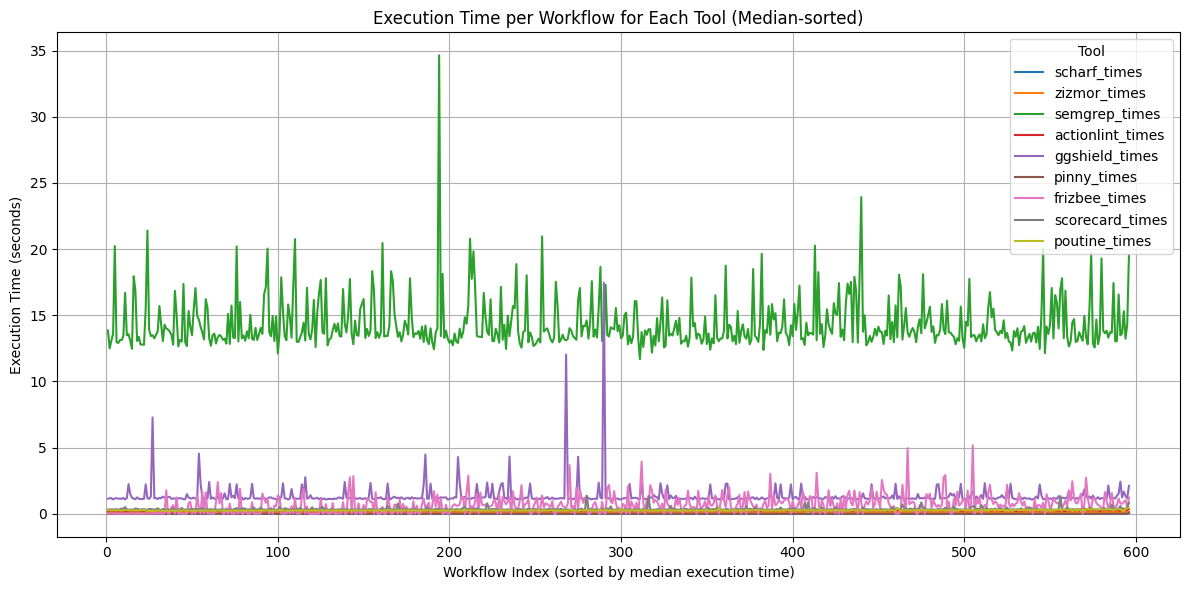

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Path to directory containing the CSVs
input_dir = Path("../results/execution_time")

# --- Load CSVs for each tool ---
tool_data = {}
for file in input_dir.glob("*.csv"):
    tool_name = file.stem
    df = pd.read_csv(file)  # expects columns: file, execution_time_seconds
    tool_data[tool_name] = df.set_index("file")

# --- Merge all into one DataFrame ---
merged_df = pd.concat(tool_data.values(), axis=1, keys=tool_data.keys())
# merged_df is a MultiIndex: (tool, execution_time_seconds)
# Flatten columns
merged_df.columns = [f"{tool}" for tool, _ in merged_df.columns]

# --- Compute median exec time per workflow ---
merged_df["median_time"] = merged_df.median(axis=1)

# --- Sort workflows by median execution time ---
merged_df = merged_df.sort_values(by="median_time")

# --- Plot ---
plt.figure(figsize=(12, 6))
workflow_index = range(1, len(merged_df) + 1)
for tool in tool_data.keys():
    plt.plot(workflow_index, merged_df[tool], label=tool)

plt.xlabel("Workflow Index (sorted by median execution time)")
plt.ylabel("Execution Time (seconds)")
plt.title("Execution Time per Workflow for Each Tool (Median-sorted)")
plt.legend(title="Tool", loc="upper right", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
from venn import venn
from collections import defaultdict

# Paths
input_dir = Path("../results/normalized")
output_dir = Path("../results/venn_all_tools")
output_dir.mkdir(parents=True, exist_ok=True)

# capability -> tool -> workflows
capability_workflow_sets = defaultdict(lambda: defaultdict(set))

# Collect workflow sets per capability and tool
for file_path in input_dir.glob("*.json"):
    workflow_name = file_path.stem
    with open(file_path, encoding="utf-8") as f:
        data = json.load(f)
    for tool, tool_data in data.get("tools", {}).items():
        for finding in tool_data.get("findings", []):
            cap = finding.get("capability")
            if cap:
                capability_workflow_sets[cap][tool].add(workflow_name)

# Generate Venn diagram for each capability
for cap, tools_dict in capability_workflow_sets.items():
    tools_with_findings = {tool: workflows for tool, workflows in tools_dict.items() if workflows}
    if len(tools_with_findings) < 2:
        continue  # skip trivial cases

    plt.figure(figsize=(8, 8))
    venn(tools_with_findings)  # library handles 2–6 sets automatically
    plt.title(f"Venn Diagram – {cap}")
    plt.tight_layout()
    plt.savefig(output_dir / f"{cap}_venn.png", dpi=300)
    plt.close()

print("[✓] Multi-set Venn diagrams saved to:", output_dir)


[✓] Multi-set Venn diagrams saved to: ../results/venn_all_tools


<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

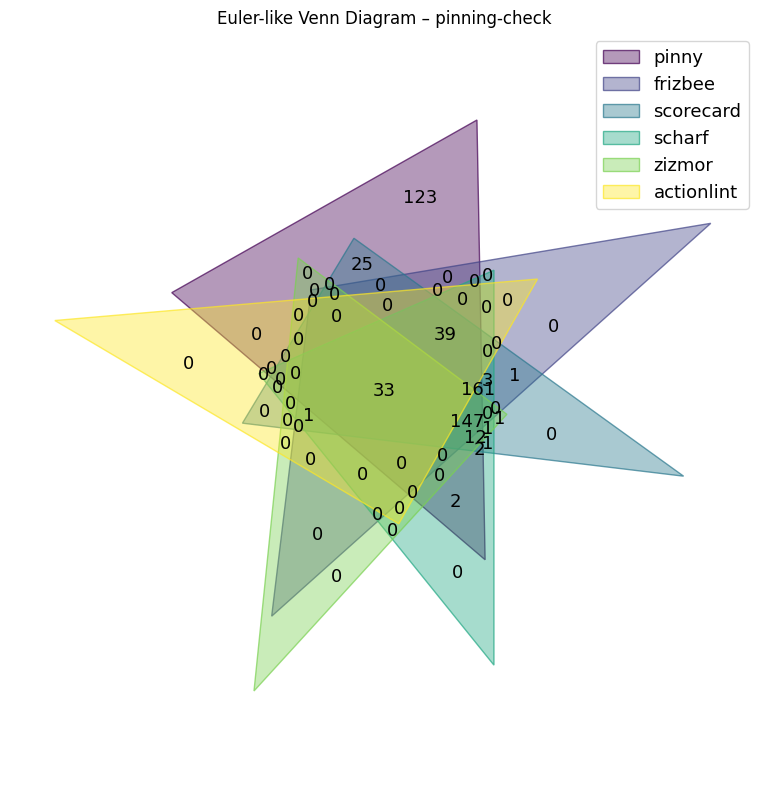

In [8]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
from venn import venn

# Paths
input_dir = Path("../results/normalized")

# Collect workflows for pinning-check
pinning_sets = {}
for file_path in input_dir.glob("*.json"):
    workflow = file_path.stem
    with open(file_path, encoding="utf-8") as f:
        data = json.load(f)
    for tool, tdata in data.get("tools", {}).items():
        for finding in tdata.get("findings", []):
            if finding.get("capability") == "pinning-check":
                pinning_sets.setdefault(tool, set()).add(workflow)

# Plot Euler-like Venn
plt.figure(figsize=(8, 8))
venn(pinning_sets)
plt.title("Euler-like Venn Diagram – pinning-check")
plt.tight_layout()
plt.savefig("../results/pinning_check_euler.png", dpi=300)
plt.show()


In [31]:
import json
from pathlib import Path
import pandas as pd
from collections import defaultdict

# Input directory with normalized JSON files
input_dir = Path("../results/normalized")

# Initialize counters
total_findings = defaultdict(int)
workflows_with_findings = defaultdict(set)

# Process all normalized files
for file_path in input_dir.glob("*.json"):
    workflow_name = file_path.stem
    with open(file_path, encoding="utf-8") as f:
        data = json.load(f)

    for tool, tool_data in data.get("tools", {}).items():
        findings = tool_data.get("findings", [])
        if findings:
            total_findings[tool] += len(findings)
            workflows_with_findings[tool].add(workflow_name)

# Build DataFrame
summary = pd.DataFrame({
    "Tool": sorted(total_findings.keys()),
    "Total Findings": [total_findings[tool] for tool in sorted(total_findings.keys())],
    "Workflows with Findings": [len(workflows_with_findings[tool]) for tool in sorted(total_findings.keys())]
})

# Display the summary table
print(summary.to_string(index=False))


      Tool  Total Findings  Workflows with Findings
actionlint             370                      143
   frizbee            2248                      384
  ggshield               1                        1
     pinny              41                       30
   poutine             237                       91
    scharf            2307                      402
 scorecard            1378                      593
   semgrep             105                       55
    zizmor            1655                      464


In [29]:
import os
import subprocess
import csv

WORKFLOW_DIR = "../.github/workflows"
FRIZBEE = "./../../tools/frizbee/frizbee"
OUTPUT_CSV = "frizbee_modification_status1.csv"

results = []
modified_count = 0

for file in sorted(os.listdir(WORKFLOW_DIR)):
    if file.endswith((".yml", ".yaml")):
        file_path = os.path.join(WORKFLOW_DIR, file)
        try:
            completed = subprocess.run(
                [FRIZBEE, "actions", "-n", file_path],
                capture_output=True,
                text=True
            )
            lines = completed.stdout.strip().splitlines()
            # If output contains more than just "Processed: file"
            modified = len(lines) > 1
            status = "modified" if modified else "unmodified"
            if modified:
                modified_count += 1
        except Exception as e:
            status = f"error: {str(e)}"
        results.append((file, status))

# Write CSV
with open(OUTPUT_CSV, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["file_name", "status"])
    writer.writerows(results)

print(f"Total modified files: {modified_count}")


Total modified files: 385


In [37]:
import os
import subprocess
import csv

WORKFLOW_DIR = "../.github/workflows"
ZIZMOR = "./../../tools/zizmor/zizmor"
OUTPUT_CSV = "zizmor_issue_status.csv"

results = []
issue_count = 0

for file in sorted(os.listdir(WORKFLOW_DIR)):
    if file.endswith((".yml", ".yaml")):
        file_path = os.path.join(WORKFLOW_DIR, file)
        try:
            completed = subprocess.run(
                [ZIZMOR, file_path],
                capture_output=True,
                text=True
            )
            stdout = completed.stdout.strip()
            if "Good job!" in stdout:
                status = "clean"
            else:
                status = "issue"
                issue_count += 1
        except Exception as e:
            status = f"error: {str(e)}"
        results.append((file, status))

# Write CSV
with open(OUTPUT_CSV, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["file_name", "status"])
    writer.writerows(results)

print(f"Total workflows with issues: {issue_count}")


Total workflows with issues: 506


In [13]:
import os
import shutil
import subprocess
import json
from pathlib import Path

RAW_WORKFLOWS = Path("../../raw_workflows")
WORKFLOW_DIR = Path("../.github/workflows")
POUTINE = Path("./../../tools/poutine/poutine")
OUTPUT_FILE = "poutine_issues_count.txt"

# Reset workflows dir
if WORKFLOW_DIR.exists():
    shutil.rmtree(WORKFLOW_DIR)
WORKFLOW_DIR.mkdir(parents=True, exist_ok=True)

total_with_issues = 0
workflow_results = {}

for wf_file in RAW_WORKFLOWS.glob("*.yml"):
    # clean dir
    for f in WORKFLOW_DIR.glob("*"):
        f.unlink()

    shutil.copy(wf_file, WORKFLOW_DIR / wf_file.name)

    result = subprocess.run(
        [str(POUTINE), "analyze_local", ".", "--format", "json"],
        capture_output=True,
        text=True
    )

    if result.returncode != 0:
        print(f"[!] Error running Poutine on {wf_file.name}")
        continue

    try:
        output_json = json.loads(result.stdout)
    except json.JSONDecodeError:
        print(f"[!] Invalid JSON output for {wf_file.name}")
        continue

    findings = output_json.get("findings", [])
    # *** Correct detection ***
    has_path_finding = any(
        "path" in finding.get("meta", {}) and
        finding["meta"]["path"].endswith((".yml", ".yaml"))
        for finding in findings
    )

    if has_path_finding:
        workflow_results[wf_file.name] = "issue"
        total_with_issues += 1
        print(f"[!] Workflow issue detected: {wf_file.name}")
    else:
        workflow_results[wf_file.name] = "clean"
        print(f"[OK] Clean workflow: {wf_file.name}")

# Save results
with open(OUTPUT_FILE, "w", encoding="utf-8") as f:
    f.write(f"Total workflows with issues: {total_with_issues}\n")
    for wf, status in workflow_results.items():
        f.write(f"{wf}: {status}\n")

print(f"\n[✓] Total workflows with issues: {total_with_issues}")
print(f"[✓] Results saved to {OUTPUT_FILE}")


[OK] Clean workflow: oracle_graal__main.yml
[OK] Clean workflow: huggingface_transformers__build_pr_documentation.yml
[OK] Clean workflow: oracle_docker-images__build-and-push-instantclient-images.yml
[OK] Clean workflow: nodejs_node__find-inactive-tsc.yml
[OK] Clean workflow: yt-dlp_yt-dlp__quick-test.yml
[OK] Clean workflow: twbs_bootstrap__lint.yml
[OK] Clean workflow: electron_electron__pipeline-electron-build-and-test-and-nan.yml
[OK] Clean workflow: twbs_bootstrap__issue-labeled.yml
[OK] Clean workflow: facebook_react__shared_label_core_team_prs.yml
[OK] Clean workflow: facebook_react__compiler_typescript.yml
[OK] Clean workflow: huggingface_transformers__self-past-caller.yml
[OK] Clean workflow: electron_electron__pipeline-segment-electron-gn-check.yml
[OK] Clean workflow: n8n-io_n8n__e2e-reusable.yml
[OK] Clean workflow: Chalarangelo_30-seconds-of-code__deploy-production.yml
[OK] Clean workflow: denoland_deno__start_release.yml
[OK] Clean workflow: denoland_deno__ci.yml
[OK] Cl

In [5]:
import json
from pathlib import Path
import pandas as pd
from collections import defaultdict

# Paths
normalized_dir = Path("../results/normalized")
output_dir = Path("../results/tool_rules_tables")
output_dir.mkdir(parents=True, exist_ok=True)

# Data structure: tool -> ( (capability, rule) -> count )
tool_capability_rule_counts = defaultdict(lambda: defaultdict(int))

for file_path in normalized_dir.glob("*.json"):
    with open(file_path, encoding="utf-8") as f:
        data = json.load(f)
    for tool, tool_data in data.get("tools", {}).items():
        for finding in tool_data.get("findings", []):
            # --- Extract rule depending on tool ---
            if tool in ["frizbee", "pinny", "scharf", "semgrep"]:
                rule = finding.get("rule", "unknown")
            elif tool == "scorecard":
                rule = finding.get("name", "unknown")
            elif tool in ["zizmor", "poutine"]:
                rule = finding.get("rule_id", "unknown")
            elif tool == "actionlint":
                msg = finding.get("message", "")
                rule = msg.split("[")[-1].replace("]", "") if "[" in msg else "generic"
            else:
                rule = finding.get("rule", "unknown")

            capability = finding.get("capability", "unknown")
            tool_capability_rule_counts[tool][(capability, rule)] += 1

# --- Export CSV per tool ---
for tool, rule_counts in tool_capability_rule_counts.items():
    rows = []
    for (capability, rule), count in rule_counts.items():
        rows.append({"Capability": capability, "Rule": rule, "Detections": count})
    df = pd.DataFrame(rows).sort_values(by=["Capability", "Detections"], ascending=[True, False])
    df.to_csv(output_dir / f"{tool}_rules_table.csv", index=False)

print(f"[✓] Per-tool rule tables saved to: {output_dir}")


[✓] Per-tool rule tables saved to: ../results/tool_rules_tables


In [9]:
import json
from pathlib import Path
import pandas as pd

# Paths
input_dir = Path("../results/normalized")
output_dir = Path("../results/selected_workflows")
output_dir.mkdir(parents=True, exist_ok=True)

# Tools of interest
tools = ["frizbee", "pinny", "scharf"]

# Data collection
unique_workflows = {tool: [] for tool in tools}
all_three_workflows = []

for file_path in input_dir.glob("*.json"):
    workflow_name = file_path.stem  # without extension
    with open(file_path, encoding="utf-8") as f:
        data = json.load(f)

    detected_tools = [t for t in tools if t in data["tools"] and data["tools"][t].get("findings")]
    
    if len(detected_tools) == 1:
        tool = detected_tools[0]
        unique_workflows[tool].append((workflow_name, data["tools"][tool]))
    elif len(detected_tools) == 3:
        all_three_workflows.append((workflow_name, [data["tools"][t] for t in tools]))

# Select top 5 unique workflows per tool and 5 for all three
for tool in tools:
    for workflow_name, tool_data in unique_workflows[tool][:5]:
        rows = []
        for f in tool_data["findings"]:
            rows.append({
                "tool": tool,
                "line": f.get("line", ""),
                "column": f.get("column", ""),
                "message": f.get("message", "")
            })
        output_file = output_dir / f"{workflow_name}_{tool}.csv"
        pd.DataFrame(rows).to_csv(output_file, index=False)

for workflow_name, tool_datas in all_three_workflows[:5]:
    rows = []
    for tdata in tool_datas:
        tool_name = tdata["tool"]
        for f in tdata["findings"]:
            rows.append({
                "tool": tool_name,
                "line": f.get("line", ""),
                "column": f.get("column", ""),
                "message": f.get("message", "")
            })
    output_file = output_dir / f"{workflow_name}_all_three.csv"
    pd.DataFrame(rows).to_csv(output_file, index=False)

print(f"[✓] CSV files saved to: {output_dir}")


[✓] CSV files saved to: ../results/selected_workflows


In [28]:
import json
import csv
from pathlib import Path
from collections import defaultdict

input_dir = Path("../results/normalized")
output_root = Path("../results/capa_det")
output_root.mkdir(parents=True, exist_ok=True)

def extract_lines(tool, finding):
    """Extract lines (Scorecard may have multiple)."""
    if tool == "scorecard" and "lines" in finding:
        return finding["lines"]
    return [finding.get("line")]

# Get all capabilities
capabilities = set()
for file_path in input_dir.glob("*.json"):
    with open(file_path, encoding="utf-8") as f:
        data = json.load(f)
    for tdata in data.get("tools", {}).values():
        for finding in tdata.get("findings", []):
            if "capability" in finding:
                capabilities.add(finding["capability"])

for capability in capabilities:
    cap_folder = output_root / capability
    cap_folder.mkdir(parents=True, exist_ok=True)

    unique_cases = []
    all_cases = []

    for file_path in input_dir.glob("*.json"):
        with open(file_path, encoding="utf-8") as f:
            data = json.load(f)

        workflow = data.get("workflow", file_path.stem)
        tool_findings = {}

        # Gather findings for this capability
        for tool, tdata in data.get("tools", {}).items():
            findings = [f for f in tdata.get("findings", []) if f.get("capability") == capability]
            if findings:
                lines = []
                for finding in findings:
                    lines.extend(extract_lines(tool, finding))
                tool_findings[tool] = sorted(set(lines))

        if not tool_findings:
            continue

        # Unique detection (one tool)
        if len(tool_findings) == 1:
            unique_cases.append((workflow, tool_findings))
        # All tools detection
        elif len(tool_findings) > 1:
            all_cases.append((workflow, tool_findings))

    # Limit to 2 workflows per case
    selected = unique_cases[:2] + all_cases[:2]

    for workflow, findings_dict in selected:
        if len(findings_dict) == 1:
            tool = list(findings_dict.keys())[0]
            file_name = f"{workflow}__{tool}.csv"
        else:
            file_name = f"{workflow}__all_tools.csv"

        out_file = cap_folder / file_name
        with open(out_file, "w", newline="") as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=["tool", "line"])
            writer.writeheader()
            for tool, lines in findings_dict.items():
                for line in lines:
                    writer.writerow({"tool": tool if len(findings_dict) == 1 else "all-tools",
                                     "line": f"{workflow}:{line}"})
    print(f"[+] Capability {capability}: {len(selected)} workflows saved")


[+] Capability permissions-check: 4 workflows saved
[+] Capability control-flow-check: 3 workflows saved
[+] Capability pinning-check: 4 workflows saved
[+] Capability trigger-permissions-check: 2 workflows saved
[+] Capability known_vulnerability-check: 2 workflows saved
[+] Capability automatic-hardening-check: 2 workflows saved
[+] Capability injection-check: 4 workflows saved
[+] Capability workflow_structural_check: 2 workflows saved
[+] Capability artifact-Integrity-check: 4 workflows saved
[+] Capability secrets-check: 4 workflows saved
